In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import multiprocessing as mp
from datetime import datetime
import sys
import gc
sys.path.append('../../')
sys.path.insert(0, '../../data/siim-pneumothorax')

from mask_functions import *
from sklearn.model_selection import KFold
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

from dependencies import *
from settings import *
from reproducibility import *
from models.TGS_salt.BesNet import BesNet as Net

Using paths on kail-main

Importing numerical libraries...
Importing standard libraries...
Importing miscellaneous functions...
Importing constants...
Importing Neural Network dependencies...
	PyTorch
	Keras
	TensorFlow
	Metrics, Losses and LR Schedulers
	Kaggle Metrics
	Image augmentations
	Datasets
Importing external libraries...
	Lovasz Losses (elu+1)

Fixing random seed for reproducibility...
	Setting random seed to 35202.

Setting CUDA environment...
	torch.__version__              = 1.1.0
	torch.version.cuda             = 9.0.176
	torch.backends.cudnn.version() = 7501
	os['CUDA_VISIBLE_DEVICES']     = 0,1
	torch.cuda.device_count()      = 2



In [2]:
SIZE = 256
FACTOR = SIZE
ne = "ne"
initial_checkpoint = None
MODEL = "ResNet34"

batch_size = 8
n_acc = 256 / batch_size
nfolds = 4

noise_th = 75.0*(SIZE/128.0)**2 #threshold for the number of predicted pixels
best_thr0 = 0.2 #preliminary value of the threshold for metric calculation

data_root = '../../data/siim-pneumothorax'
torch.cuda.set_device('cuda:1')

In [3]:
def time_to_str(time, str):
    #if str == 'min':
    #	    return str(round(float(time)/60,5))+" min(s)"
    return round(time,4)

In [4]:
#TODO: Instead of directly printing to stdout, copy it into a txt file
class Logger():
    def __init__(self,name=MODEL+ne):
        super().__init__()
        self.model=name
        #if OHEM != "OHEM":
        #    self.model=MODEL+ne[ne.find("_")+1:]
        self.file = open(self.model+"_bes_log.txt","w+")
        self.file.close()
        
        self.debug_file = open(self.model + '_bes_debug.txt', 'w+')
        self.debug_file.close()
    def write(self, str):
        print(str)
        self.file = open(self.model+"_bes_log.txt","a+")
        self.file.write(str)
        self.file.close()
    def write2(self, str):
        print(str, end='',flush=True)
        self.file = open(self.model+"_bes_log.txt","a+")
        self.file.write(str)
        self.file.close()
    def debug(self, str):
        self.debug_file = open(self.model + '_bes_debug.txt', 'a+')
        self.debug_file.write(str)
        self.debug_file.close()
    def stop():
        self.file.close()
        self.debug_file.close()
        
log = Logger()

In [5]:
def valid_augment(image,mask,index):
    cache = Struct(image = image.copy(), mask = mask.copy())
    # image, mask = do_resize2(image, mask, SIZE, SIZE)
    # image, mask = do_center_pad_to_factor2(image, mask, factor = FACTOR)
    return image,mask,index,cache

def train_augment(image,mask,index):
    cache = Struct(image = image.copy(), mask = mask.copy())

    if np.random.rand() < 0.5:
         image, mask = do_horizontal_flip2(image, mask)
         pass

    if np.random.rand() < 0.2:
        c = np.random.choice(4)
        if c==0:
            image, mask = do_random_shift_scale_crop_pad2(image, mask, 0.1) #0.125

        if c==1:
            image, mask = do_horizontal_shear2( image, mask, dx=np.random.uniform(-0.02,0.02) )
            pass

        if c==2:
            image, mask = do_shift_scale_rotate2( image, mask, dx=0, dy=0, scale=1, angle=np.random.uniform(0,15))  #10

        if c==3:
            image, mask = do_elastic_transform2(image, mask, grid=10, distort=np.random.uniform(0,0.05))#0.10
            pass
    if np.random.rand() < 0.1:
        c = np.random.choice(3)
        if c==0:
            image = do_brightness_shift(image,np.random.uniform(-0.1,+0.1))
        if c==1:
            image = do_brightness_multiply(image,np.random.uniform(1-0.08,1+0.08))
        if c==2:
            image = do_gamma(image,np.random.uniform(1-0.08,1+0.08))
        # if c==1:
        #     image = do_invert_intensity(image)

    # image, mask = do_resize2(image, mask, SIZE, SIZE)
    # image, mask = do_center_pad_to_factor2(image, mask, factor = FACTOR)
    return image,mask,index,cache

In [6]:
def null_augment(image, mask, index):
    cache = Struct(image = image.copy(), mask = mask.copy())
    return image, mask, index, cache

def null_collate(batch):

    batch_size = len(batch)
    cache = []
    input = []
    truth = []
    index = []
    for b in range(batch_size):
        input.append(batch[b][0])
        truth.append(batch[b][1])
        index.append(batch[b][2])
        cache.append(batch[b][3])
    input = torch.from_numpy(np.array(input)).float().unsqueeze(1)

    if truth[0]!=[]:
        truth = torch.from_numpy(np.array(truth)).float().unsqueeze(1)

    return input, truth, index, cache

def get_weights_for_balanced_classes(cls_list, num_classes):
    # get count per class
    count = [0] * num_classes
    
    for cls in cls_list:
        count[cls] += 1

    # get weight per class
    weight_per_class = [0.] * num_classes
    N = float(len(cls_list))
    
    for i in range(num_classes):
        weight_per_class[i] = N / float(count[i])
        
    #　get weight per sample
    weights = [0] * len(cls_list)
    
    for i, cls in enumerate(cls_list):
        weights[i] = weight_per_class[cls]
        
    return weights

def get_boundary(masks):
    mask_arr = (masks.cpu().numpy() * 255).astype(np.uint8).squeeze()
    b_arr = []
    
    for mask in mask_arr:
        b_img = np.zeros(mask.shape)
        
        contours, hier = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        cv2.drawContours(b_img, contours, -1, 255, 1)
        
        b_arr.append(b_img)
        
    b_arr = np.stack(b_arr)
    
    return torch.from_numpy(b_arr)

class SIIMDataset(Dataset):
    def __init__(self, data_root, fold, pos_neg_ratio=0.5, width=1024, height=1024, phase='train', augment=null_augment, random_state=2019, nfolds=4):
        self.data_root = data_root
        self.fold = fold
        self.height = width
        self.width = height
        self.phase = phase
        self.augment = augment
        
        kf = KFold(n_splits=nfolds, shuffle=True, random_state=random_state)
        train_list = os.listdir(os.path.join(data_root, 'train_png'))
        
        if phase == 'train':
            index_list = list(kf.split(list(range(len(train_list)))))[fold][0]
            self.filenames = [train_list[i] for i in index_list]
            
            # read masks for pos/neg ratio sampler
            train_df = pd.read_csv(os.path.join(self.data_root, 'train-rle.csv'))
            pos_ids = list(train_df[train_df[' EncodedPixels']!=' -1']['ImageId'])

            self.cls_list = [1 if filename.split('.png')[0] in pos_ids else 0 for filename in self.filenames]

        elif phase == 'val':
            index_list = list(kf.split(list(range(len(train_list)))))[fold][1]
            self.filenames = [train_list[i] for i in index_list]
        else: # test
            self.filenames = os.listdir(os.path.join(data_root, 'test_png'))

    def __getitem__(self, index):
        png_path = 'test_png' if self.phase == 'test' else 'train_png'
        img_path = os.path.join(self.data_root, '{}/{}'.format(png_path, self.filenames[index]))
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.
        img = cv2.resize(img, (self.width, self.height), interpolation = cv2.INTER_AREA)
        
        if self.phase == 'test':
            mask = []
        else: # train and val
            mask_path = os.path.join(self.data_root, 'mask_png/{}'.format(self.filenames[index]))
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.
            mask = cv2.resize(mask, (self.width, self.height), interpolation = cv2.INTER_AREA)
        
        return self.augment(img, mask, index)
    
    def __len__(self):
        return len(self.filenames)

In [7]:
def get_dataloaders(data_root, batch_size, fold, nfolds=4, width=1024, height=1024, train_augment=null_augment, val_augment=null_augment, random_state=SEED):
    train_dataset = SIIMDataset(
        data_root,
        fold,
        width=width, height=height,
        phase='train',
        augment=train_augment,
        random_state=random_state,
        nfolds=nfolds
    )
    
    weights = get_weights_for_balanced_classes(train_dataset.cls_list, 2)
    weights = torch.DoubleTensor(weights)
    balance_sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

    train_loader  = DataLoader(
        train_dataset,
        # sampler     = RandomSampler(train_dataset),
        sampler = balance_sampler,
        batch_size  = batch_size,
        drop_last   = True,
        num_workers = 8,
        pin_memory  = True,
        collate_fn  = null_collate
    )

    val_dataset = SIIMDataset(
        data_root,
        fold,
        width=width, height=height,
        phase='val',
        augment=val_augment,
        random_state=random_state,
        nfolds=nfolds
    )

    val_loader  = DataLoader(
        val_dataset,
        # sampler     = RandomSampler(val_dataset),
        batch_size  = batch_size,
        drop_last   = False,
        num_workers = 8,
        pin_memory  = True,
        collate_fn  = null_collate
    )
    
    return train_loader, val_loader

In [8]:
# TTA with flip-lr

def tta(net, loader):
    net.set_mode('test')
    
    all_m_probs = []
    all_b_probs = []
    all_truths = []
    
    with torch.no_grad():
        with tqdm(total=len(loader), file=sys.stdout) as pbar:
            for input, truth, index, cache in loader:
                input = input.cuda()

                m_logits, b_logits = net(input)
                m_probs = F.sigmoid(m_logits)
                b_probs = F.sigmoid(b_logits)

                all_m_probs.append(m_probs)
                all_b_probs.append(b_probs)
                if len(truth[0]) != 0:
                    all_truths.append(truth)

                pbar.update(1)
            
        i = 0
        with tqdm(total=len(loader), file=sys.stdout) as pbar:
            # tensor.shape = [N, C, H, W], so we flip dim -1
            for input, truth, index, cache in loader:
                input = input.cuda()
                input = torch.flip(input, [-1])

                m_logits, b_logits = net(input)
                m_probs = F.sigmoid(m_logits)
                b_probs = F.sigmoid(b_logits)

                m_probs = torch.flip(m_probs, [-1])
                b_probs = torch.flip(b_probs, [-1])

                all_m_probs[i] += m_probs
                all_m_probs[i] *= 0.5
                all_b_probs[i] += b_probs
                all_b_probs[i] *= 0.5

                i += 1
                pbar.update(1)

        all_m_probs = torch.cat(all_m_probs, dim=0)
        all_b_probs = torch.cat(all_b_probs, dim=0)
        if len(all_truths) != 0:
            all_truths = torch.cat(all_truths, dim=0)
    
    gc.collect()
    torch.cuda.empty_cache()
    
    return all_m_probs, all_b_probs, all_truths

In [9]:
#dice for threshold selection

def dice_overall(preds, targs):
    n = preds.shape[0]
    
    preds = preds.view(n, -1)
    targs = targs.view(n, -1)
    
    targs = (targs > 0.5).float()
    
    intersect = (preds * targs).sum(-1).float()
    union = (preds + targs).sum(-1).float()
    
    # get 1 for both empty pred and targ
    u0 = union==0
    intersect[u0] = 1
    union[u0] = 2
    
    return (2. * intersect / union)

In [10]:
train_loader, val_loader = get_dataloaders(
    data_root,
    batch_size,
    0, nfolds=10,
    width=SIZE, height=SIZE,
    train_augment=train_augment, val_augment=valid_augment,
    random_state=SEED
)

net = Net().cuda()

In [11]:
net.load_state_dict(torch.load('bes-cp-20190813-140556-2.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## eval

In [12]:
m_probs, b_probs, truths = tta(net, val_loader)

# grid search
# search best noise threshold and score threshold for this fold
scores, best_thrs = [],[]
thrs = np.arange(0.01, 1, 0.01)
n_thrs = np.arange(5, 150, 5)

truths = truths.cuda()

with tqdm(total=len(n_thrs), file=sys.stdout) as pbar:
    for n_th in n_thrs:
        probs = m_probs.clone()
        probs = probs.cuda()
        
        # probs[probs.view(probs.shape[0], -1).sum(-1) < n_th*(SIZE/128.0)**2,...] = 0.0
        
        dices = []
        for th in thrs:
            preds = (probs>th).float()
            preds[preds.view(preds.shape[0], -1).sum(-1) < n_th*(SIZE/128.0)**2,...] = 0.0
            dices.append(dice_overall(preds, truths).mean().cpu().item())
            
        scores.append(dices)
        
        pbar.update(1)

scores = np.array(scores)

  0%|          | 0/134 [00:00<?, ?it/s]

/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

  0%|          | 0/134 [00:00<?, ?it/s]

/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

  1%|          | 1/134 [00:00<01:18,  1.70it/s]

/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


100%|██████████| 29/29 [01:41<00:00,  3.54s/it]


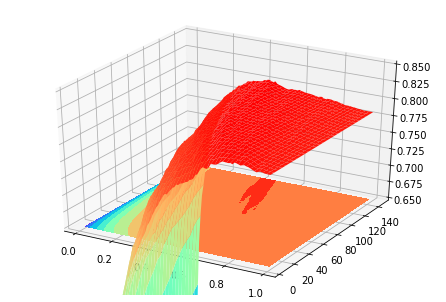

In [13]:
X, Y = np.meshgrid(thrs, n_thrs)

fig = plt.figure()
ax = Axes3D(fig)

ax.plot_surface(X, Y, scores, cmap='rainbow')
ax.contourf(X, Y, scores, zdir='z', offset=0.65, cmap='rainbow')
ax.set_zlim(0.65, 0.85)

plt.show()

In [14]:
max_score = np.max(scores)
n_thr_idx, thr_idx = np.unravel_index(np.argmax(scores), scores.shape)

best_thr = thrs[thr_idx]
best_n_thr = n_thrs[n_thr_idx]

print('max_score: {}, best_thr: {}, best_n_thr: {}'.format(max_score, best_thr, best_n_thr))

max_score: 0.803335964679718, best_thr: 0.49, best_n_thr: 125


In [15]:
# compute dice for tp, fn, fp, tn

def dice_detail(preds, targs):
    n = preds.shape[0]
    
    tp = []
    tn = 0
    fp = 0
    fn = 0
    
    preds = preds.view(n, -1)
    targs = targs.view(n, -1)
    
    targs = (targs > 0.5).float()
    
    for i in range(n):
        pred = preds[i]
        targ = targs[i]
        
        if pred.sum() == 0: # tn + fn
            if targ.sum() == 0:
                tn += 1
            else:
                fn += 1
        else: # tp + fp
            if targ.sum() == 0:
                fp += 1
            else:
                intersect = (pred * targ).sum().float()
                union = (pred + targ).sum().float()
                dice = 2. * intersect / union
                
                tp.append(dice.cpu().item())
    
    return tp, tn, fp, fn

In [16]:
# compute dice for tp, fn, fp, tn

probs = m_probs.clone()
probs = probs.cuda()

# get pred
preds = (probs>best_thr).float()
preds[preds.view(preds.shape[0], -1).sum(-1) < best_n_thr*(SIZE/128.0)**2,...] = 0.0

tp, tn, fp, fn = dice_detail(preds, truths)

In [17]:
print('tp: {} ({}), tn: {}, fp: {}, fn: {}'.format(len(tp), np.mean(tp), tn, fp, fn))

tp: 62 (0.5350987219041393), tn: 828, fp: 11, fn: 171


## test

In [18]:
test_dataset = SIIMDataset(
    data_root,
    0,
    width=SIZE, height=SIZE,
    phase='test',
    augment=null_augment,
    random_state=SEED,
    nfolds=10
)

test_loader  = DataLoader(
    test_dataset,
    # sampler     = RandomSampler(val_dataset),
    batch_size  = batch_size,
    drop_last   = False,
    num_workers = 8,
    pin_memory  = True,
    collate_fn  = null_collate
)

In [19]:
m_probs, b_probs, truths = tta(net, test_loader)

100%|██████████| 173/173 [00:20<00:00,  8.86it/s]


In [22]:
# post-processing

probs = m_probs.clone().cuda()

# noise removal
probs[probs.view(probs.shape[0], -1).sum(-1) < best_n_thr*(SIZE/128.0)**2,...] = 0.0

# leakage
ids = [filename.rsplit('.', 1)[0] for filename in test_dataset.filenames]
leak_sample_df = pd.read_csv(os.path.join(data_root, "sample_submission_leak.csv"))
masks_ = leak_sample_df.groupby('ImageId')['ImageId'].count().reset_index(name='N')
masks_ = masks_.loc[masks_.N > 1].ImageId.values
for i, uid in enumerate(ids):
    if uid in masks_:
        probs[i] = m_probs[i]

# get binary mask
preds = (probs>best_thr).long()

masks = preds.cpu().numpy().squeeze() * 255

In [20]:
# post-processing with late noise removal

m_probs = m_probs.cuda()

# get binary mask
preds = (m_probs>best_thr).long()
m_preds = preds.clone()

# noise removal
preds[preds.view(preds.shape[0], -1).sum(-1) < best_n_thr*(SIZE/128.0)**2,...] = 0.0

# leakage
ids = [filename.rsplit('.', 1)[0] for filename in test_dataset.filenames]
leak_sample_df = pd.read_csv(os.path.join(data_root, "sample_submission_leak.csv"))
masks_ = leak_sample_df.groupby('ImageId')['ImageId'].count().reset_index(name='N')
masks_ = masks_.loc[masks_.N > 1].ImageId.values
for i, uid in enumerate(ids):
    if uid in masks_:
        preds[i] = m_preds[i]

masks = preds.cpu().numpy().squeeze() * 255

In [21]:
# Generate rle encodings in parallel (images are first converted to the original size)
mask_size = 1024

def mask_worker(mask):
    im = PIL.Image.fromarray((mask.T).astype(np.uint8)).resize((mask_size, mask_size))
    im = np.asarray(im)

    rle = mask2rle(im, mask_size, mask_size)
    
    return rle

pool = mp.Pool()
rle_list = pool.map(mask_worker, masks)

In [22]:
# ok, export submission csv
ids = [filename.rsplit('.', 1)[0] for filename in test_dataset.filenames]

sub_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': rle_list})
sub_df.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'

sub_df.to_csv('bes_sub.csv', index=False)

sub_df.head(20)

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6106.151787519...,-1
1,1.2.276.0.7230010.3.1.4.8323329.6588.151787519...,-1
2,1.2.276.0.7230010.3.1.4.8323329.6014.151787519...,-1
3,1.2.276.0.7230010.3.1.4.8323329.6813.151787520...,-1
4,1.2.276.0.7230010.3.1.4.8323329.699.1517875164...,-1
5,1.2.276.0.7230010.3.1.4.8323329.6236.151787519...,622732 4 1020 4 1020 4 1020 4 1016 16 1008 16 ...
6,1.2.276.0.7230010.3.1.4.8323329.6680.151787519...,-1
7,1.2.276.0.7230010.3.1.4.8323329.6967.151787520...,-1
8,1.2.276.0.7230010.3.1.4.8323329.6923.151787520...,-1
9,1.2.276.0.7230010.3.1.4.8323329.6744.151787519...,-1
